In [1]:
%load_ext itikz
import itikz
from itikz import nicematrix as nM
import jinja2

import numpy as np
import sympy as sp

<div style="float:center;width:100%;text-align:center;"><strong style="height:100px;color:darkred;font-size:40px;">LU Decomposition</strong>
</div>

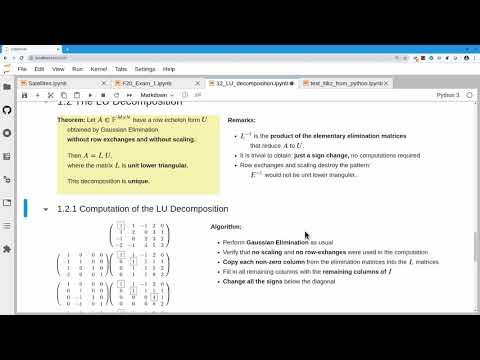

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo("2dPnMYfbQiI", 400, 200, frameborder="0",
      allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture",
      allowfullscreen=True)

# 1. Basic Idea

## 1.1 Multiple Right-hand Sides

#### **Main Example**

Consider solving the problem $A x = b$ for many different righthand sides:

<!--
A  = sp.Matrix([[1,0,0,0],[1,1,0,0],[-1,1,1,0],[3,-2,1,1]]) * sp.Matrix([[1,1,-1,2,0],[0,1,2,1,1],[0,0,1,4,1],[0,0,0,1,-1]]);
A[:,2] = -2*A[:,0] + A[:,1]
A[3,:] = A[0,:] - A[1,:] + 2*A[2,:]
x  = sp.Matrix([[-1,1,0,1,2],[0,1,1,1,1]]).T; b = A * x
Ab = A.col_insert( A.shape[1], b)

matrices = [[None, Ab]]; pivots = []; txt=[]

E1=sp.eye(4);E1[1:,0]=-Ab[1:,0]/A[0,0]; A1=E1*Ab;matrices.append([E1,A1]); pivots.append((1,1))
E2=sp.eye(4);E2[2:,1]=-A1[2:,1]/A1[1,1];A2=E2*A1;matrices.append([E2,A2]); pivots.append((2,2))
E3=sp.eye(4);E3[3:,2]=-A2[3:,2]/A2[2,2];A3=E3*A2;matrices.append([E3,A3]); pivots.append((3,3))
pivots.append((4,4))

mat_rep, submatrix_locs, pivot_locs, txt_with_locs,mat_format = nM.ge_layout( matrices, Nrhs=2, pivots=pivots, txt=txt, formater=lambda x: sp.latex(x))

itikz.fetch_or_compile_svg( jinja2.Template( nM.GE_TEMPLATE ).render( preamble=nM.preamble, extension=nM.extension,
             mat_rep=mat_rep, mat_format=mat_format, submatrix_locs=submatrix_locs, pivot_locs=pivot_locs, txt_with_locs=txt_with_locs),
                            prefix='lin_dep_', working_dir='/tmp/itikz', debug=False,
                            **itikz.build_commands_dict(use_xetex=True,use_dvi=False,crop=True), nexec=4, keep_dir="." )
-->
<div>
<div style="float:left;padding-right:0cm;width:35%;"><img src="Figs/lu_multiple_rhs.svg"></div>
<!-- div style="float:left;margin-left:1cm;padding-left:1cm;border-left:2px solid black;height:4.3cm;"-->
<div style="float:left;width:55%;margin-left:2cm;">

**Remarks:** 
* The elementary operation matrices **do not change:**<br>
    $\qquad$ they are derived from the matrix $A$,<br>
    $\qquad$ independently from the $b$ vectors
* Algebraically, we **find matrices** $E_1, E_2, E_3$<br>
    $\qquad$ that introduce **zeros underneath the pivots**:<br>
* Upon completion, we have reduced the matrix $A$ to **row echelon form** $U$.
    
    
* **Adding a new right-hand side** only needs to compute the column<br>$\qquad$  under that right-hand side as the computation proceeds.
* **Just update $b$ as we move down** the stack!
</div></div>

#### **Algebraic Representation**

<div style="float:left;padding-right:0.4cm;width:35%;height:7cm;border-right: 2px solid black;">

Giving the matrices in the layout names,<br>
    $\qquad$ we have carried out the following operations:

<img src="Figs/abstract_matrix_stack.svg" style="width:8cm;">
</div><div style="float:left;width:55%;padding-top:0.0cm;padding-left:0.5cm;">

Algebraically, we find matrices $E_1, E_2, E_3$ that introduce zeros underneath the pivots:<br>
$\qquad$
$\begin{align} (\xi)
& \quad \Leftrightarrow \quad A\ x &=&\; b_i, \qquad\qquad\quad \text{ for } i = 1, 2 \dots \\
& \quad \Leftrightarrow \quad E_1 A\ x &=&\; E_1 b_i \\
& \quad \Leftrightarrow \quad \dots & \dots & \\
& \quad \Leftrightarrow \quad \left( E_k E_{k-1} \dots E_2 E_1 \right) A\ x &=&\;  \left( E_k E_{k-1} \dots E_2 E_1 \right) b_i \\
& \quad \Leftrightarrow \quad \color{red}{U}\ x &=&\;  \color{red}{y_i} \\
\end{align}
$

$U$ is a **row echelon form** of $A$:$\quad$ we solve $A x = b \Leftrightarrow U x = y$
    in two steps,<br>
    $\quad$ $\color{red}{(A \mid b) \sim (U \mid y)}$ $\quad$ by Gaussian Elimination,<br>
    $\quad$ $\color{red}{(U \mid y)}$ $\quad\qquad\quad\;\;$ by backsubstitution.
</div></div>

#### **Two Approaches**

Let's study the following two cases:
<div style="float:left;padding-left:1cm;padding-right:2cm;">
$$
\begin{align}
E &= E_k E_{k-1} \dots E_2 E_1 \\
U &= E A, \quad y = E b
\end{align}
$$
<br><br>
i.e., solve $A x = b$ by computing $\left\{ \begin{align} y =& E b \\ U x =& y \end{align} \right.$
</div>
<div style="float:left;padding-left:2cm;padding-right:1cm;border-left: 2px solid black;">
$$
\begin{align}
& E^{-1} = E_1^{-1} E_2^{-1} \dots E_k^{-1} \\
& A      = E^{-1} U, \quad b = E^{-1} y
\end{align}
$$
<br><br>
i.e., solve $A x = b$ by computing $\left\{ \begin{align} E^{-1} y =& b \\ U x =& y \end{align} \right.$
</div>

##### **Precompute $\mathbf{E}$**

<div style="float:left;width:40%;">
<br>
Compute the product ${E} = E_k E_{k-1} \dots E_2 E_1$<br>
$\quad$ For our example $k=3.$
<br><br>
<img src="Figs/lu_prod_E.svg">
</div>
<div style="float:left;padding-top:0cm;padding-left:1cm;width:55%;">

* Comparing this product to the original $E_1, E_2, E_3$ matrices,<br>
  $\quad$ we see that the first subdiagonal in the product<br>
  $\quad$ is a copy of the corresponding entries in $E_i$ (shown in red).<br>
  $\quad$ The **remaining entries in blue are different:<br>
   $\quad$ they require computation.**

* We have done **additional computations** to compute $E$,<br>
  $\quad$ while the number of operations required to<br>
  $\quad$ compute $y = E b$ **remained the same**
</div>

##### **Precompute the inverse of** $\mathbf{E}$

<div style="float:left;width:40%;">
<br>
Compute the product $E^{-1} = E_1^{-1} E_2^{-1} \dots E_k^{-1}$<br>
$\quad$ For our example $k=3.$
<br><br>
<img src="Figs/lu_prod_Ei.svg">

* The **colums fill in** when we add columns<br>$\quad$ from left to right in this product of matrices
</div>
<div style="float:left;padding-top:1.9cm;padding-left:1.5cm;">
* We have **factored** the matrix $\color{red}{A = E^{-1} U}$
* Comparing this product to the original $E_1, E_2, E_3$ matrices,<br>
   $\qquad$ we see that the columns in the product (shown in red)<br>
   $\qquad$ just copy into place!.<br>
* There is only a **sign change** applied below the diagonal of $E_i$
* **No additional computations were required**.
</div>

<div style="float:left;padding-right:1cm;">
    
**Remarks:**
* The colums fill in when we add columns<br>
   $\quad$ from left to right in this product of matrices<br>
   $\quad$ **provided** there is **no row exchange**
* Scaling (an entry other than 1 on the diagonal) **does fill in**,<br>
  $\quad$ but **the inverse requires scaling**<br>
  $\quad$ in addition to a sign change.
</div>

<div style="float:left;padding-left:0.5cm;border-left: 2px solid black;height:4.5cm;">

The matrix $E^{-1}$ has **special properties** provided
* **Gaussian Elimination** reduces $A$ to row echelon form
    * **without row exchanges** (this may not be possible)
    * and **without scaling**   (this is a choice)
* It is **invertible** and **unit lower triangular:**<br>
$\quad$ $\color{red}{\boxed{L = E^{-1},\quad A = L\ U}}$
</div>

## 1.2 The LU Decomposition

<div style="float:left;background-color:#F2F5A9;color:black;padding-right:0.5cm;height:4.8cm;">

**Theorem:** Let $A \in \mathbb{F}^{M \times N}$ have a row echelon form $U$<br>
$\quad$ obtained by Gaussian Elimination<br>
$\quad$ **without row exchanges and without scaling.**

$\quad$ Then $A = L\ U$,<br>
$\quad$ where the matrix $L$ is
    **unit lower triangular.**

$\quad$ This decomposition is **unique.**
</div>
<div style="float:left;padding-left:0.5cm;width:50%">

**Remarks:**
* $L^{-1}$ is the **product of the elementary elimination matrices**<br>$\quad$ that reduce $A$ to $U$.
* It is trivial to obtain: **just a sign change,** no computations required
* Row exchanges and scaling destroy the pattern:<br>$\quad$ $E^{-1}$ would not be unit lower triangular.. 
</div>

### 1.2.1 Computation of the LU Decomposition

<div>
<div style="float:left;padding-right:0cm;width:30%;"><img src="Figs/lu_example.svg"></div>
<!-- div style="float:left;margin-left:1cm;padding-left:1cm;border-left:2px solid black;height:4.3cm;"-->
<div style="float:left;width:60%;margin-left:2cm;">

**Algorithm:**
* Perform **Gaussian Elimination** as usual
* Verify that **no scaling** and **no row-exhanges** were used in the computation 
* **Copy each non-zero column** from the elimination matrices into the $L$ matrices
* Fill in all remaining columns with the **remaining columns of $I$**
* **Change all the signs** below the diagonal

<br><br>
* **Check** the result by multiplying $L U$ to get $A$.
</div></div>

### 1.2.2 Use the LU Decomposition to Solve $\ $ A x = b

#### **First Righthand Side b**

##### **L y = b $\ $ By Forward Substitution**

Continuing our example with the right-hand side $b = ( 2, 6, 8, 12 )$,<br>$\qquad$ solve $L y = b$:
<div>
<div style="float:left;padding-left:1cm;padding-right:1cm;"><img src="Figs/lu_example_b1_1.svg"></div>
<div style="float:left;padding-left:1cm;padding-right:1cm;"><img src="Figs/lu_example_b1_systeme.svg" style=";height:1.8cm;"></div>
<div style="float:left;;padding-left:1cm;padding-right:1cm;"><img src="Figs/lu_example_b1_2.svg"  style=";height:1.8cm;"></div>
</div>

##### **U x = y  $\ $ By Backward Substitution**

<!--
%%itikz --temp-dir --scale 0.8 --file-prefix test_ --template article --tex-packages=amssymb,cascade,systeme,nicematrix,tikz,relsize --crop --tikz-libraries=decorations.pathreplacing

% ==================================================================================== Decorate matrix
\NiceMatrixOptions{code-for-last-row = \color{blue}, code-for-first-row = \color{red}}
$\begin{pNiceArray}{*5r|r}[left-margin = 4pt, first-col, last-row,
    code-before =
    {
    % ----------------------------------------------------------------------- Row-echelon form Path
    \tikz \draw[red] (row-1-|col-1) -- (row-2-|col-1)
                  -- (row-2-|col-2) -- (row-3-|col-2)
                  -- (row-3-|col-4) -- (row-4-|col-4)
                  -- (row-4-|col-7);
    }
]
    & \color{red}{\mathbf{1}}   & 1                       & -1 &  2                       &  0 & \;  2 \\
    & 0                         & \color{red}{\mathbf{1}} &  1 &  1                       &  1 & \;  4 \\
    & 0                         & 0                       &  0 &  \color{red}{\mathbf{4}} &  1 & \;  6 \\
    & 0                         & 0                       &  0 &  0                       &  0 & \;  0 \\
% ------------------------------------------------------------------------------------ Basic and Free Variables
\color{blue}{\begin{matrix} \\ \text{basic}\\ \text{free} \end{matrix}}
    & \begin{array}{r} x_1        \\             \end{array}
    & \begin{array}{r} x_2        \\             \end{array}
    & \begin{array}{r}            \\  x_3=\alpha \end{array}
    & \begin{array}{r} x_4        \\             \end{array}
    & \begin{array}{r}            \\  x_5=\beta  \end{array}
    &
\end{pNiceArray}$
% ==================================================================================== Solve by Back-substitution
\vspace{1cm}       % below the figure; inkscape cropping fails otherwise...

% ------------------------------------------------------------------------------------ Solve
    {\ShortCascade%
       {\ShortCascade%
          {\ShortCascade%
             {$\boxed{x_3 = \alpha, x_5=\beta}\;$}%
             {$x_4 = \frac{1}{4}{(6 - x_5)}$}%
             {$\;\Rightarrow\; \boxed{x_4 = \frac{3}{2} - \frac{1}{4}\beta}$}%
          }%
          {$x_2 = 4 -x_3-x_4-x_5$}%
          {$\;\Rightarrow\; \boxed{x_2 = \frac{5}{2} - \alpha - \frac{3}{4}\beta}\;$}%
       }%
       {$x_1 = 2 - x_2 + x_3 - 2 x_4 $}%
       {$\;\Rightarrow \; \boxed{x_1 =  -\frac{7}{2}+2 \alpha+\frac{5}{4}\beta}.$}
    }%
%& % --------------------------------------------------------------------------------- Standard Form
\vspace{0.3cm}

%
    {$\; \therefore\;       \left( \begin{array}{r} x_1 \\ x_2 \\ x_3 \\ x_4 \\ x_5 \end{array} \right)
                    = \frac{1}{2} \left( \begin{array}{r}  -7  \\  5 \\   0 \\   3 \\   0 \end{array} \right)
                    + \alpha \left( \begin{array}{r}  2  \\  -1 \\   1 \\   0 \\   0 \end{array} \right)
                    + \frac{1}{4} \beta \left( \begin{array}{r}  5  \\  -3 \\   0 \\  -1 \\  4 \end{array} \right)
         $
    }
-->
Solving $U x = y$ by backsubstitution, we have

<div style="float:left;padding-right:1cm;"> <img src="Figs/lu_example_b1_4.svg" style="width:6cm;"> </div>
<div style="float:left;padding-right:1cm;"> <img src="Figs/lu_example_b1_5.svg" style="width:10cm;"> </div>
<div style="float:left;">                   <img src="Figs/lu_example_b1_6.svg" style="width:6cm;"> </div>

#### **The Algorithm**

<div>
<div style="float:left;padding-right:0cm;width:45%;">

$\quad
\begin{align}
A x = b \quad & \Leftrightarrow \quad L (U x) = b \\
              & \Leftrightarrow \quad
\left\{ \begin{aligned} \color{red}{L y} & \color{red}= & \color{red}b \\ \color{red}{U x} & \color{red}= & \color{red}y\end{aligned} \right.
\end{align}
$
</div>
<div style="float:left;width:45%;padding-left:1.0cm;border-left: 2px solid black;height:2.6cm;">

**Forward / Backward:**
* Solve $L y = b$ for $y$ by **forward substitution**
* Solve $U x = y$ for $x$ by **backsubstitution**
</div></div>

#### **Another Right-hand Side**

##### **Forward Substitution**

Continuing our example with a new right-hand side $b = ( 2, 6, 7, 10 )$,<br>$\qquad$ solve $L y = b$:<br>

<div>
<div style="float:left;padding-left:1cm;padding-right:1cm;"><img src="Figs/lu_example_b2_1.svg"></div>
<div style="float:left;padding-left:1cm;padding-right:1cm;"><img src="Figs/lu_example_b2_systeme.svg" style=";height:1.8cm;"></div>
<div style="float:left;padding-left:1cm;padding-right:1cm;"><img src="Figs/lu_example_b2_2.svg"  style=";height:1.8cm;"></div>
</div>

##### **Backward Substitution**

Solving $U x = y$ by backsubstitution,<br>$\qquad$ and using the fact that the **homogeneous solution does not change**

<div style="float:left;padding-right:1cm;"> <img src="Figs/lu_example_b2_4.svg" style="width:6cm;"> </div>
<div style="float:left;padding-right:1cm;"> <img src="Figs/lu_example_b2_5.svg" style="width:9cm;"> </div>
<div style="float:left;">                   <img src="Figs/lu_example_b2_6.svg" style="width:7cm;"> </div>

# 2. The PLU Decomposition

## 2.1 Required Row Exchange(s)

This leaves a question: what if we have to do row exchanges?

Gaussian Elimination proceeds a row at a time.<br>
$\quad$ If at some point we require exchanging rows $i_1$ and $i_2$,<br>
$\quad$ it is easy to see that **the problem would have been avoided**<br>
$\quad$ if we had interchanged rows $i_1$ and $i_2$ of the $A$ matrix **prior to doing GE**

Introductory Linear Algebra texts tend instruct the reader to interchange the rows of $A$<br>
$\qquad$ and **start over.**

Duplicating work is **easy to avoid,** however.

### 2.1.1 Example

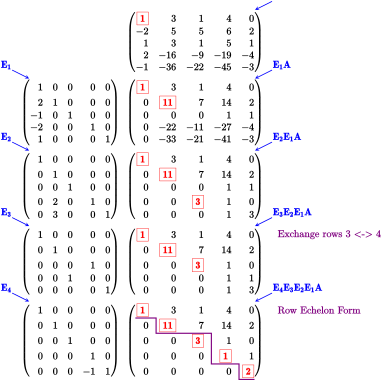

In [3]:
def plu():
    A  = sp.Matrix([[ 1,    3,    1,    4,   0],
                    [-2,    5,    5,    6,   2],
                    [ 1,    3,    1,    5,   1],
                    [ 2,  -16,   -9,  -19,  -4],
                    [-1,  -36,  -22,  -45,  -3]])


    E1 = sp.Matrix([[ 1, 0, 0, 0, 0],[ 2, 1, 0, 0, 0],[ -1, 0, 1, 0, 0],[ -2, 0,  0, 1, 0], [1, 0, 0, 0, 1]]); A1 = E1 * A
    E2 = sp.Matrix([[ 1, 0, 0, 0, 0],[ 0, 1, 0, 0, 0],[  0, 0, 1, 0, 0],[  0, 2,  0, 1, 0], [0, 3, 0, 0, 1]]); A2 = E2 * A1
    E3 = sp.Matrix([[ 1, 0, 0, 0, 0],[ 0, 1, 0, 0, 0],[  0, 0, 0, 1, 0],[  0, 0,  1, 0, 0], [0, 0, 0, 0, 1]]); A3 = E3 * A2
    E4 = sp.Matrix([[ 1, 0, 0, 0, 0],[ 0, 1, 0, 0, 0],[  0, 0, 1, 0, 0],[  0, 0,  0, 1, 0], [0, 0, 0,-1, 1]]); A4 = E4 * A3

    matrices = [[None,A],[E1,A1],[E2,A2],[E3,A3],[E4,A4]]
    pivots=[(1,1),(2,2),None,(3,3)]

    txt=["","","", "Exchange rows 3 <-> 4","Row Echelon Form"]

    h,m = nM.ge( matrices, #Nrhs=1,
              pivot_list=[ [(0,1), [(0,0)] ],
                           [(1,1), [(0,0),(1,1)]],
                           [(2,1), [(0,0),(1,1),(3,2)]],
                           [(3,1), [(0,0),(1,1),(2,2)]],
                           [(4,1), [(0,0),(1,1),(2,2),(3,3),(4,4)]],
                           ],
             ref_path_list = [ [4,1, [(0,0),(1,1),(2,3),(3,3),(4,4)],'hh'] ],
             comment_list = txt,
             array_names = ['E', 'A'],
             tmp_dir="/tmp/itikz", keep_file="/tmp/itikz/plu"
    )

    Ei = E1.inv()*E2.inv()*E3.inv()*E4.inv()
    return h,Ei
h,Ei=plu()
h

If we look at $E^{-1} = E_1^{-1} E_2^{-1} E_3^{-1} E_4^{-1}$ ,<br>
$\quad$ we see that **the matrix is no longer unit lower-triangular!**

$\qquad$ $E^{-1} = \left( \begin{matrix}1 & 0 & 0 & 0 & 0\\ -2 & 1 & 0 & 0 & 0\\ 1 & 0 & \color{red}0 & \color{red}1 & 0\\ 2 & -2 & \color{red}1 & \color{red}0 & 0\\ -1 & -3 & 0 & 1 & 1 \end{matrix}\right)$

#### **Investigation**

If we investigate, we see that **the problem** arises with the **row exchange** matrix $E_3^{-1}$:<br>
$\quad$ let us set $E_3^{-1} = P$, to emphasize it is a **permutation matrix**

$\quad$ Let's leave it out of the multiplication, and look at $E^{-1} = \left( E_1^{-1} E_2^{-1} \right)\ P\  E_4^{-1}$:

$\qquad E^{-1} \; = \; \begin{pmatrix} \color{purple}1 & 0 & 0 & 0 & 0 \\
 -2 & \color{purple}1  &0 &0 &0 \\
  1 & 0 &\color{purple}1 &0 &0 \\
  2 &-2 &0 &\color{purple}1 &0 \\
 -1 &-3 &0 &0 &\color{purple}1 \end{pmatrix}\; P\;
\begin{pmatrix}\color{purple}1& 0& 0&  0&  0 \\
 0 & \color{purple}1 & 0 & 0 & 0 \\
 0 & 0 & \color{purple}1 & 0 & 0 \\
 0 & 0 & 0 & \color{purple}1 & 0 \\
 0 & 0 & 0 & 1 & \color{purple}1\end{pmatrix}
$

$\quad$ The product of the first and third matrix above would be **unit lower triangular** as before.

#### **The Fix: Push P to the Left**

**Could we somehow pull the second matrix to the left?**

$\quad$ Since $E_3^{-1}$ is a permutation matrix, let's change notation and call it $P = E_3^{-1}$.<br>
$\quad$ and denote the matrix to its left $\tilde{E} = E_1^{-1} E_2^{-1}$.

$\quad$ The question we are asking is
whether we could interchange $\tilde{E}$ and $P$ in $E^{-1} = \tilde{E} P E_3^{-1}$.

$\qquad\qquad \tilde{E} P = P {\color{red}{\hat{E}}} \; \Leftrightarrow \; {\color{red}{\hat{E}}} = P^{-1} \tilde{E} P = P \tilde{E} P \;\; \text{ since }\; P\; \text{is invertible}$

##### **First Look at $\;\;$ P Ẽ**

Let's see:

$\qquad
P^{-1} \tilde{E} = \begin{pmatrix}
  1 &  0 & 0 & 0 & 0\\
 -2 &  1 & 0 & 0 & 0\\
  \color{purple}2 & \color{purple}{-2} & \color{red}0 & \color{red}1 & 0\\
  \color{purple}1 &  \color{purple}0 & \color{red}1 & \color{red}0 & 0\\
 -1 & -3 & 0 & 0 & 1 \end{pmatrix} \quad \text{ has diagonal elements out of place}
$

$\quad$ so $P$ does indeed **interchange the corresponding rows,** but in the process, **it displaces the 1 entries on the diagonal!**

##### **Now Multiply P Ẽ by P**

Multiplying this matrix with $P$ from the right **fixes up the 1 entries:**

$\qquad
P \tilde{E} = \begin{pmatrix}
  1 &  0 & 0 & 0 & 0\\
 -2 &  1 & 0 & 0 & 0\\
  \color{purple}2 & \color{purple}{-2} & \color{red}1 & \color{red}0 & 0\\
  \color{purple}1 &  \color{purple}0 & \color{red}0 & \color{red}1 & 0\\
 -1 & -3 & 0 & 0 & 1 \end{pmatrix}
$

The end result: **pulling the row exchange matrix to the left exchanges the row entries below the diagonal.**<br>
$\quad$ This is the right form so that the product of the elimination matrices are unit lower triangular as before.

#### **A = P L U**

We can repeatedly push row exchange matrices to the left as we encounter them in $E^{-1} = E_1^{-1} E_2^{-1} \dots E_k^{-1}$

The end result: we will have split $\color{red}{A = P L U},$ where<br>
* $P$ is **a permutation matrix**  (a product of all the row exchange matrices)
* $L$ is a **unit lower triangular matrix**
* $U$ is a **row echelon form matrix**

##### **PLU for this Example**

$\qquad \begin{align} E^{-1} U \;& = \;
\begin{pmatrix} \color{purple}1 & 0 & 0 & 0 & 0 \\
 -2 & \color{purple}1  &0 &0 &0 \\
  1 & 0 &\color{purple}1 &0 &0 \\
  2 &-2 &0 &\color{purple}1 &0 \\
 -1 &-3 &0 &0 &\color{purple}1 \end{pmatrix}\; P\;
\begin{pmatrix}\color{purple}1& 0& 0&  0&  0 \\
 0 & \color{purple}1 & 0 & 0 & 0 \\
 0 & 0 & \color{purple}1 & 0 & 0 \\
 0 & 0 & 0 & \color{purple}1 & 0 \\
 0 & 0 & 0 & 1 & \color{purple}1\end{pmatrix}\; U
\\
&= \;
P \begin{pmatrix}
  1 &  0 & 0 & 0 & 0\\
 -2 &  1 & 0 & 0 & 0\\
  \color{purple}2 & \color{purple}{-2} & \color{red}1 & \color{red}0 & 0\\
  \color{purple}1 &  \color{purple}0 & \color{red}0 & \color{red}1 & 0\\
 -1 & -3 & 0 & 1 & 1 \end{pmatrix} \; U
 \end{align}
$

### 2.1.2 Solving $\;$ P L U x = b

$\qquad$ $\left. \begin{align} & A x &=&\ b \\ & A &=&\ P L U \end{align} \right\} \quad \Leftrightarrow  \quad P (L U x) = b \quad \Leftrightarrow \quad $
$\left\{ \; \begin{align} P w &=&\ b \\ L U x  &=&\ w \end{align} \right.$

The **first equation is trivial**: it is a permutation of the entries of $b,$ i.e., $w = P^t b$,<br>
$\quad$ followed by the **forward/backward solution** of $L U = w$.

## 2.2 Variations

### 2.2.1 The PLDU Decomposition

At times, it proves convenient to pull out the pivots from the row echelon form matrix,<br>
$\quad$ i.e., scale the pivots to 1:

> $\quad$ As an example, consider
>
> $\qquad$ $\begin{align}\left( \begin{matrix} \color{red}2 & 4 & 6 & 4 \\
                          0 & \color{red}3 & 6 & -9 \\
                          0 & 0 & 0 & \color{red}6 \end{matrix} \right)
   &= \begin{pmatrix} \color{red}2 & 0 & 0 \\ 0 & \color{red}3 & 0 \\ 0 & 0 & \color{red}6 \end{pmatrix}
           \begin{pmatrix} \frac{1}{2} & 0 & 0 \\ 0 & \frac{1}{3} & 0 \\ 0 & 0 & \frac{1}{6} \end{pmatrix}
           \left( \begin{matrix} 2 & 4 & 6 & 3 \\
                          0 & 3 & 6 & -9 \\
                          0 & 0 & 0 & 6 \end{matrix} \right)\\
           &=
           \begin{pmatrix} \color{red}2 & 0 & 0 \\ 0 & \color{red}3 & 0 \\ 0 & 0 & \color{red}6 \end{pmatrix}
           \left( \begin{matrix} \color{red}1 & 2 & 3 & 2 \\
                          0 & \color{red}1 & 2 & -3 \\
                          0 & 0 & 0 & \color{red}1 \end{matrix} \right)
\end{align}
$<br><br>
>$\quad$ the product of a diagonal matrix $D$ and a row echelon form matrix $U$ with pivots equal to 1.

Applying this to a PLU decomposition, and renaming the $U$ matrix, we obtain the decomposition<br>
$\qquad$ $A = P L D U,\;$ where
* $P$ is a **permutation matrix**
* $L$ is a **unit lower triangular matrix**
* $D$ is a **diagonal matrix**
* $U$ is a matrix in **row echelon form**

**Remark:**<br>
$\qquad$ The PLU Decomposition is **not unique**

### 2.2.2 Symmetric Matrices

For the special case of a **symmetric matrix** that has an $LU$ decomposition,<br>
$\quad$ scaling the pivots to 1 result in<br>
$\qquad \color{red}{A = L D L^t}$

i.e., the row echelon form of $A$ is the transpose of the $L$ matrix.

<div style="float:left;background-color:#F2F5A9;color:black;padding-right:3mm;">

**Theorem:** Let $A$ be a **symmetric matrix.** <br>
$\qquad$ The decomposition $A = L D L^t$ exists iff $A$ has an LU decomposition,<br>
$\qquad$ i.e., $A$ can be reduced to row echelon form without row exchanges.

**Example**

> The matrix $A = \begin{pmatrix} 0 & 1 & 0 \\ 1 & 0 & 1 \\ 0 & 1 & 0 \end{pmatrix}$<br>
>
> does not have an $L D L^t$ decomposition.

# 3. Take Away

* A matrix $A$ can be decomposed into a product $A = P L U,\;$ where
    * $P$ is a **permutation matrix**
    * $L$ is a **unit lower triangular** matrix
    * $U$ is a **row echelon form matrix**

* The PLU decomposition results from a reordering of the computations in **Gaussian Elimination**
* The PLU decomposition lets us solve $A x = b$ with the **forward / backward** algorithm

* If Gaussian Elimination reduces $A$ to row echelon form **without requiring row exchanges,**<br>
$\quad$ then $A = L U$
* A symmetric matrix $A = L D L^t$, where $L$ is **unit lower triangular** and $D$ is **diagonal** iff<br>
$\quad$ $A$ has an LU decompostion